In [8]:
!pip install kaggle
!pip install tensorflow
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://rtprepo.na.seeds.basf.net/pypiserver, https://pypi.python.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 414.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 1.2 MB/s eta 0:00:00ta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73050 sha256=45589f1578002c4faf0b6b83868e4eb175606a3431d7efbb5be5ae2e1347f560
  Stored in directory: /home/baekjo/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

api = KaggleApi()
api.authenticate()

# download the dataset into current directory
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                          'train.tsv.zip', path='./')

# extract the file to CSV with zipfile
with zipfile.ZipFile('train.tsv.zip', 'r') as z:
    z.extractall('./')

2022-03-27 12:00:20,503 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe1f8d10be0>: Failed to establish a new connection: [Errno -2] Name or service not known')': /api/v1/competitions/data/download/sentiment-analysis-on-movie-reviews/train.tsv.zip
2022-03-27 12:00:21,739 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe1f8484280>: Failed to establish a new connection: [Errno -2] Name or service not known')': /api/v1/competitions/data/download/sentiment-analysis-on-movie-reviews/train.tsv.zip
2022-03-27 12:00:21,999 WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at

MaxRetryError: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/competitions/data/download/sentiment-analysis-on-movie-reviews/train.tsv.zip (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe1f8484310>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [76]:
import pandas as pd
df = pd.read_csv('train.tsv', sep="\t")

In [77]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [78]:
df.drop_duplicates(subset="SentenceId", keep="first", inplace=True)

In [79]:
## Check length for padding

In [80]:
len(df)

8529

## Check the length distribution of phrase

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/tools/eb/software/biogrid_python/3.8.6-foss-2020b/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Phrase', ylabel='Density'>

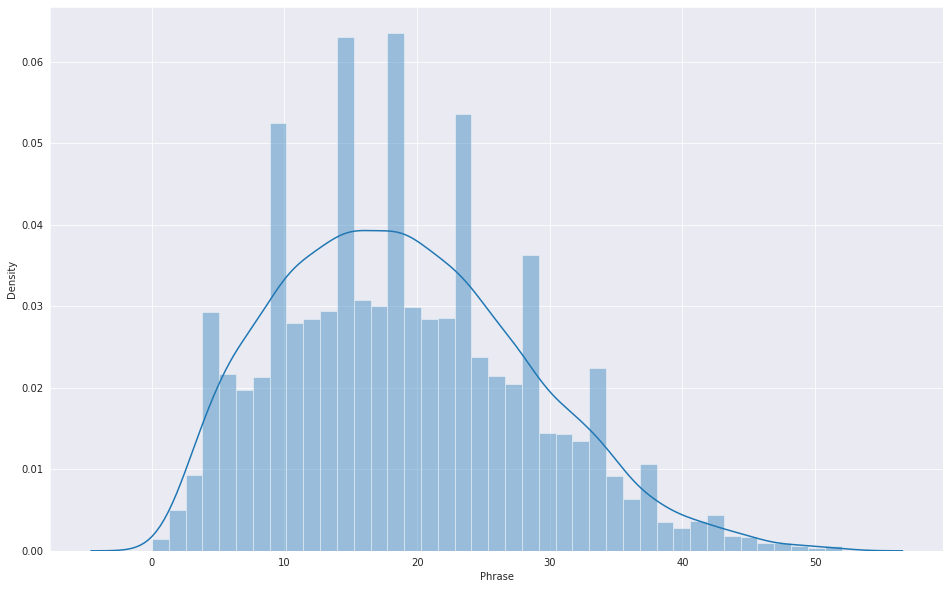

In [82]:
seq_len = df['Phrase'].apply(lambda x: len(x.split()))

sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
sns.distplot(seq_len)

In [83]:
SEQ_LEN = 50  # we will cut/pad our sequences to a length of 50 tokens

In [84]:
import numpy as np
from transformers import AutoTokenizer

In [85]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [86]:
tokens = tokenizer.encode_plus("Hello World", max_length=SEQ_LEN,
                            truncation=True, padding='max_length',
                            add_special_tokens=True, return_attention_mask=True,
                            return_token_type_ids=False, return_tensors='tf')

In [87]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[ 101, 8667, 1291,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [88]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [89]:
# initialize two arrays for input tensors
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

for i, sentence in enumerate(df['Phrase']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i)  # do this so we can see some progress

0


In [90]:
Xids

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

In [91]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [92]:
arr = df['Sentiment'].values  # take sentiment column in df as array
labels = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
labels[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value

In [93]:
df['Sentiment'].values

array([1, 4, 1, ..., 1, 1, 2])

In [94]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [95]:
import tensorflow as tf

BATCH_SIZE = 32  # we will use batches of 32

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(100000).batch(BATCH_SIZE)

In [96]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.9  # 90-10 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

del dataset  # optionally, delete dataset to free up disk-space

## Model definition
Our data is now ready and we can define our model architecture. We will use BERT, followed by an LSTM layer, and some simple NN layers. Those final layers following BERT are our classifier.

Our classifier consumes the output hidden state tensors from BERT — using them to predict whether we’re seeing something with positive or negative sentiment.

In [28]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://rtprepo.na.seeds.basf.net/pypiserver, https://pypi.python.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.9 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [97]:
import tensorflow as tf
from transformers import AutoModel
from transformers import TFAutoModel

# initialize cased BERT model
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(50,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(50,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [98]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                          

## Training
First, we set up our optimizer (Adam), loss function, and accuracy metric. Then, we compile the model and train!

In [99]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(train, validation_data=val, epochs=120)

Epoch 1/120
240/240 [==============================] - 171s 650ms/step - loss: 1.3825 - accuracy: 0.4007 - val_loss: 1.2670 - val_accuracy: 0.4146
Epoch 2/120
240/240 [==============================] - 154s 640ms/step - loss: 1.2537 - accuracy: 0.4431 - val_loss: 1.2207 - val_accuracy: 0.4193
Epoch 3/120
240/240 [==============================] - 155s 645ms/step - loss: 1.2286 - accuracy: 0.4520 - val_loss: 1.1144 - val_accuracy: 0.4971
Epoch 4/120
240/240 [==============================] - 155s 646ms/step - loss: 1.2138 - accuracy: 0.4643 - val_loss: 1.1363 - val_accuracy: 0.5018
Epoch 5/120
240/240 [==============================] - 155s 647ms/step - loss: 1.1897 - accuracy: 0.4742 - val_loss: 1.0975 - val_accuracy: 0.5347
Epoch 6/120
240/240 [==============================] - 155s 648ms/step - loss: 1.1842 - accuracy: 0.4826 - val_loss: 1.0737 - val_accuracy: 0.5489
Epoch 7/120
240/240 [==============================] - 156s 648ms/step - loss: 1.1708 - accuracy: 0.4904 - val_loss: 1